In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sys.path.insert(0, '../scripts')
from utils import *

In [ ]:
plt.style.use('seaborn')

In [2]:
plt.rcParams['figure.figsize'] = (12, 10)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using MXNet backend.


In [5]:
import datetime
import time

In [19]:
from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, Merge, Flatten, Dense, Reshape, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.engine.topology import merge

In [8]:
train_data = pd.read_csv('../data/clean-train.csv').dropna(axis=0)
test_data = pd.read_csv('../data/clean-test.csv').dropna(axis=0)

In [9]:
q1_list = train_data['q1'].tolist()
q2_list = train_data['q2'].tolist()

In [10]:
vocab_size = 10000

In [12]:
token = Tokenizer(nb_words=vocab_size)
token.fit_on_texts(q1_list + q2_list)

In [13]:
question1_seq = token.texts_to_sequences(q1_list)
question2_seq = token.texts_to_sequences(q2_list)

In [14]:
MAX_SEQUENCE_LENGTH = 25

In [15]:
q1_data = pad_sequences(question1_seq, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(question2_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [16]:
train_labels = train_data['is_same'].values

In [31]:
MAX_SEQUENCE_LENGTH = 25
WORD_EMBEDDING_DIM = 300
SENT_EMBEDDING_DIM = 128
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 150
DROPOUT = 0.2
BATCH_SIZE = 516
nb_words = vocab_size

In [32]:
gpus = 8
gpu_list = []
for i in range(gpus):
    gpu_list.append('gpu({:.0f})'.format(i))

In [33]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

q1 = Embedding(nb_words + 1, 
                 WORD_EMBEDDING_DIM, 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
q1 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q1)

q2 = Embedding(nb_words + 1, 
                 WORD_EMBEDDING_DIM, 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
q2 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q2)

attention = merge([q1,q2], mode='dot', dot_axes=1)
attention = Flatten()(attention)
attention = Dense((MAX_SEQUENCE_LENGTH*SENT_EMBEDDING_DIM))(attention)
attention = Reshape((MAX_SEQUENCE_LENGTH, SENT_EMBEDDING_DIM))(attention)

merged = merge([q1,attention], mode='sum', concat_axis=1)
merged = Flatten()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

In [34]:
model = Model([question1,question2], is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'], context=gpu_list)

In [ ]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint('./checkpoint-test', monitor='val_acc', save_best_only=True)]
history = model.fit([q1_data, q2_data],
                    train_labels,
                    nb_epoch=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2017-12-11 23:09:53.212430
Train on 291067 samples, validate on 32341 samples
Epoch 1/150


/home/ubuntu/src/anaconda3/envs/keras1.2_p3/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:385: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.001937984496124031). Is this intended?
  force_init=force_init)


291067/291067 [==============================] - 156s - loss: 0.6483 - acc: 0.6268 - val_loss: 0.6654 - val_acc: 0.6370
Epoch 2/150
291067/291067 [==============================] - 154s - loss: 0.5892 - acc: 0.6845 - val_loss: 0.6120 - val_acc: 0.6711
Epoch 3/150
291067/291067 [==============================] - 154s - loss: 0.5694 - acc: 0.7017 - val_loss: 0.5934 - val_acc: 0.6848
Epoch 4/150
291067/291067 [==============================] - 155s - loss: 0.5569 - acc: 0.7102 - val_loss: 0.5700 - val_acc: 0.7053
Epoch 5/150
291067/291067 [==============================] - 153s - loss: 0.5490 - acc: 0.7162 - val_loss: 0.5630 - val_acc: 0.7035
Epoch 6/150
291067/291067 [==============================] - 153s - loss: 0.5420 - acc: 0.7209 - val_loss: 0.5951 - val_acc: 0.6640
Epoch 7/150
291067/291067 [==============================] - 153s - loss: 0.5356 - acc: 0.7256 - val_loss: 0.5676 - val_acc: 0.6994
Epoch 8/150
291067/291067 [==============================] - 155s - loss: 0.5297 - acc: 

In [37]:
q1_list_test = test_data['q1'].tolist()
q2_list_test = test_data['q2'].tolist()

question1_seq_test = token.texts_to_sequences(q1_list_test)
question2_seq_test = token.texts_to_sequences(q2_list_test)

q1_data_test = pad_sequences(question1_seq_test, maxlen=MAX_SEQUENCE_LENGTH)
q2_data_test = pad_sequences(question2_seq_test, maxlen=MAX_SEQUENCE_LENGTH)

test_labels = test_data['is_same'].values

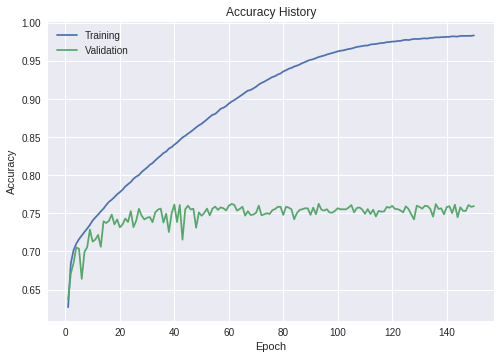

In [39]:
plt.plot(np.arange(1, 151), history.history['acc'], label='Training')
plt.plot(np.arange(1, 151), history.history['val_acc'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy History')
plt.legend()

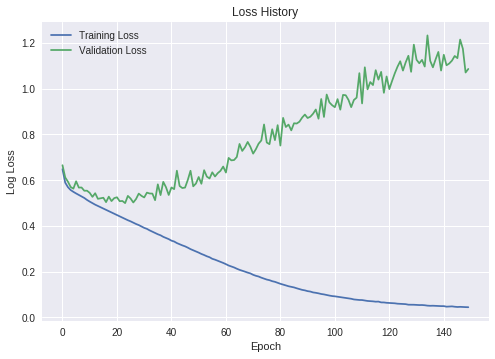

In [40]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Loss History')
plt.legend()

In [41]:
preds = model.predict([q1_data_test, q2_data_test]).flatten()

In [42]:
classes = (preds > 0.5).astype('int').flatten()

In [43]:
generate_report(test_labels, classes.flatten(), preds.flatten())

Loss Report
-----------

Accuracy Score: 0.7613
ROC  AUC Score: 0.8137
Log Loss Score: nan


/home/ubuntu/src/anaconda3/envs/keras1.2_p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/ubuntu/src/anaconda3/envs/keras1.2_p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


(0.76126103841492077, 0.81370307018033516, nan)